<a href="https://colab.research.google.com/github/yunigma/Kaldi-for-ASR-of-Swiss-German/blob/master/Practical1_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

- Train a linear model
    - using least squares method
    - implement the model from scratch using NumPy 
    - Use learning curves plot to understand whether the linear model is overfitting or underfitting
- Train linear models with 
    - regularization (Ridge and Lasso)
    - polynomial basis expansion
    - use validation data to choose the hyperparameters
    - scikit-learn
    - Optional task: Use k-fold cross validation to choose the optimal hyperparameters (5 bonus points)

We will use the following packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

We will use the winequality dataset for this practical. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality. 
In order to make it easier to import the dataset, the dataset has been converted to the numpy array format and shuffled, so that we can start the practical directly. The converted dataset is available on the OLAT page.

The dataset has two files. We’ll focus on the white wine data, which is the larger dataset. The following code loads the data:

In [3]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# load the white wine dataset
# X is the feature matrix that stores the feature values of the data records
# y is the label vector that stores the labels of the data records
X, y = cp.load(open('/content/gdrive/My Drive/Colab Notebooks/winequality-white.pickle', 'rb'))
#X, y = cp.load(open('sample_data/winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a {} matrix, which contains {} data records and {} features.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a {}-dimentional vector, which stores the corresponding labels of the data records in X".format(y.shape[0]))


X is a (4898, 11) matrix, which contains 4898 data records and 11 features.
y is a 4898-dimentional vector, which stores the corresponding labels of the data records in X


We next split the data into training data and test data. 
In practice, we should sample randomly 80% of the data as training data and the rest as the test data. . 
However, in order to get consistent results, we use the first 80% of the data as training
data and the remaining as the test data. 
To achieve this split, we define the following function.

In [5]:
# The function splits the dataset into training data and testing data.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset goes to the training dataset 
# and the remaining data goes to the test dataset.
def split_data(X, y, split_coeff):
    N, _ = X.shape # get the number of records (rows)
    train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
    X_train = X[:train_size] # the first training_size records
    y_train = y[:train_size]
    X_test = X[train_size:] # the last test_size records
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # split the data with split_coeff=0.8

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


## Understanding What We’re Predicting

Let’s first check
the distribution of the y-values in the training data. 
You will find that the values are integers between 3 and 9 indicating the quality of the wine.


### **Task 1**
Make a bar chart showing the distribution of y-values in the training data. You will find that the y-values are integers from 3 to 9, which indicate the quality of the wines.

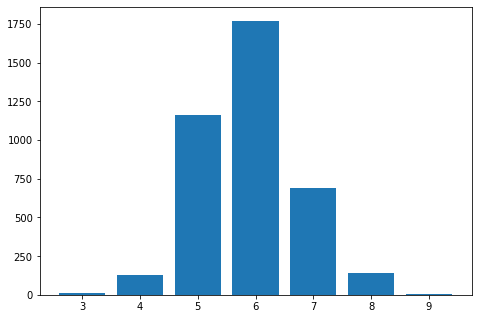

In [6]:
#@title
# Task 1: 
# the function takes the y-values in the training data as the input and makes the bar chart. 
# Hint: Your function should make a bar chart looks like the bar chart below.
def plot_bar_chart_score(y_train):
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    wine_quality, counts = np.unique(y_train, return_counts=True)
    ax.bar(wine_quality, counts)
    plt.show()
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

plot_bar_chart_score(y_train)

### **Task 2** 
This task is to build a trivial predictor, which always returns the mean of the y-values of the training data. We consider the trivial model as a baseline. The linear regression models we build later should perform better than this trivial model. 

In [7]:
#@title
# Task 2: implement the trivial predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
    # The code below is just for compilation. 
    # You need to delete it and write your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hint: return the mean of y_train
    average = float(round(sum(y_train) / len(y_train)))
    return average
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The trivial predictor returns the average value.
def trivial_predictor(X_test, y_train_avg):
  # preds = [y_train_avg for point in X_test]
  return y_train_avg

# trivial_predictions = trivial_predictor(X_test, y_train_avg)
# print(trivial_predictions[:10])

Average of y on the training label values is 6.0


### **Task 3**
We next evaluate the trivial predictor on the training data and test data. 
We use mean squared error (MSE) to measure the performance of the predictor.
The task is to implement a function that reports the mean squared error of the given predictor on the given data. 

In [8]:
# We next test our trivial predictor on the training data and test data. 
# Implement a function that can report the mean squared error 
# of a predictor on the given data
# Input: data and predictor
# Output: mean squared error of the predictor on the given data
def test_predictor(X, y, predictor: callable=None):
    # Apply the predictor to each row of the matrix X to get the predictions
    y_predicted = np.apply_along_axis(predictor, 1, X)

    # TODO: compute the mean squared error of y
    # The code below is just for compilation. 
    # You need to delete it and write your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    errors = [(pair[0] - pair[1])**2 for pair in zip(y, y_predicted)]
    mse = sum(errors) / len(errors)
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    return mse

# use the function test_predictor to test the trivial predictor
# we use the lambda function here to pass the function trivial predictor to the function test_predictor.
mse_trivial_predictor_train = test_predictor(X_train, y_train, lambda x: trivial_predictor(x, y_train_avg))
mse_trivial_predictor_test = test_predictor(X_test, y_test, lambda x: trivial_predictor(x, y_train_avg))

# Report the result
print('Trivial Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_trivial_predictor_train)
print('MSE (Testing)  = %.4f' % mse_trivial_predictor_test)

Trivial Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7915
MSE (Testing)  = 0.8296


## Train the Linear Model Using Least Squares Method

Let us train a linear model on the training data and then check its MSE. 
We use the closed form solution of the least squares estimate to get the parameters of the linear model. 
The linear model should perform better than the trivial predictor.

### **Task 4**
Before training the model, we need to standardize the data, i.e., transform the data so that every feature has mean 0 and variance 1. 

https://en.wikipedia.org/wiki/Standard_score

We first standardize the training data. 
Then we apply the same transformation to the test data, i.e. standardize the test data using the means and the standard deviations of the training data. 

In [9]:
# The task is to implement a function that can standardize the data and returns the mean and std of the data.
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    # TODO: compute the means and standard deviations of the data, and standardize the data
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    mean = np.sum(X, axis=0) / len(X)
    # mean_n = np.mean(X, axis=0)
    std = np.sqrt(np.sum(np.subtract(X, mean)**2, axis=0) / len(X))
    # std_n = np.std(X, axis=0)
    X_std = np.subtract(X, mean) / std 
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    return X_std, mean, std

# Standardize the training data and store the means and the stds 
X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

#print(X_train[:5,:5])
#print(X_train_std[:5,:5])

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [10]:
# TODO: Standardize the test data using the means and standrad deviations of the training data
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
X_test_std = np.subtract(X_test, X_train_mean) / X_train_std_div
print(X_test_std.shape)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

(980, 11)


### **Task 5**
We have standardized X-values. Do we need to standardize the y-values? Why?

(Add the answer to Task 5 here in text)

No, we do not need to standardize the y-values. The y-values are target labels, or the output values, of the system. If they are normalized, the interpretation of the predictions should be adjusted. 

### **Task 6**
Let's now train the linear model using the least-squares method. 
We need to add the bias term to the matrix X. 

In [11]:
# The task is to implement the function that adds a column of ones to the front of the input matrix
def expand_with_ones(X):
    # TODO: add a column of ones to the front of the input matrix
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    n = X.shape[0]
    X_out = np.c_[ np.ones(n), X ] 
    return X_out
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

# Train the linear model using the least-squares method
# The task is to implement the function that computes the parameters
def least_squares_compute_parameters(X_input, y):
    # add the bias column to the data
    X = expand_with_ones(X_input)

    # TODO: compute the parameters based on the expanded X and y using the least-squares method
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    w = np.linalg.lstsq(X, y, rcond=None)[0]
    return w
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

# Apply the function to train the linear model
w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)

w: (12,)


After computing the parameters,
we can build the linear model predictor.
The predictor takes as input the computed parameters and the data, and predicts the labels for the input data.

In [12]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    # TODO: predict the labels for the input data
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    y_hat = np.sum(np.multiply(w, X))
    return y_hat
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################


We can now evaluate our linear model predictor on the test data. 

In [13]:
# use the function test_predictor to evaluate the linear model predictor
mse_linear_model_predictor = test_predictor(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283477


## Learning Curves

Let us check if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, the model shouldn't be overfitting. 
To check it, we need to check the learning curves, i.e. how the performance of the model changes when it is trained with increasingly more data. 
We train the model on the increasingly more data ([20, 40, ..., 600] data records), and evaluate the model by computing the MSE of the model on both the training data and the test data. 
We use the collected MSE to build the learning curves plot. 

### **Task 7** 

Let's first implement a function that comprises what we have implemented above. 
The function takes as inputs the data and the split coefficient, and
1. standardizes the data,
2. trains the linear model, and
3. reports the mse of the linear model predictor on both training and test datasets. 

In [14]:
# Input: training data and test data
# Output: mse of the linear model predictor on both the training and test data
def train_and_test(X_train, y_train, X_test, y_test):
    # TODO: implement the function 
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hints: use the functions you have implemented
    # Standardize the training and test data: 
    X_train_std, _, _ = standardize_data(X_train)
    X_test_std, _, _ = standardize_data(X_test)

    # Compute the parameters:
    w = least_squares_compute_parameters(X_train_std, y_train)

    # Get MSE for train and test:
    mse_train = test_predictor(expand_with_ones(X_train_std), y_train, lambda x: linear_model_predictor(x, w))
    mse_test = test_predictor(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))

    return mse_train, mse_test
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

mse_train, mse_test = train_and_test(X_train, y_train, X_test, y_test)
print('Linear Model')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


Linear Model
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5621


We are now ready to report the learning curves.
The task is to train the linear model on the increasingly more data ([20, 40, ..., 600] data records)
and store the MSE of the trained model on the training data and the test data in the lists `mse_train_v` and `mse_test`, respectively. 
We have provided the code for generating the learning curves from `mse_train_v` and `mse_test`.

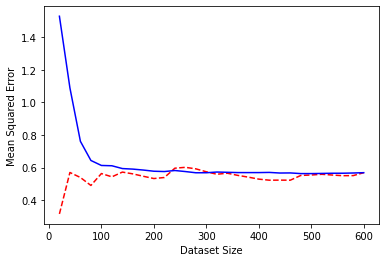

In [15]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the MSE over data with sizes from TRAINING_SIZE_MIN to TRAINING_SIZE_MAX with increasing step 20
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
    # TODO: 
    #   1. use the first train_size data records from the X_train and y_train as the training data
    #   2. train and compute the MSE on both training and test data using the train_and_test function
    #   3. add the computed MSE to the lists mse_train_v and mse_test_v
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    X_sub_train = X_train[:train_size] # the first training_size records
    y_sub_train = y_train[:train_size]

    mse_train, mse_test = train_and_test(X_sub_train, y_sub_train, X_test, y_test)
    
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    

# The below code generates the learning curves plot
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

### **Task 8**
Explain whether you think the model is underfitting or not and how much data you need before getting the optimal test error.

(Add the answer to Task 8 here in text)

No, the model does not underfit, as the MSE improves for the test set until it gets very close to the results on the train data. It looks like more data would not help much to improve the test error, as already starting with the data size equals 100-200 no big improvement is noticeable. 

## Polynomial Basis Expansion and Regularisation

In this part, we will try to improve the linear model by basis expansion and regularisation. 

The task is to 
1. apply the degree 2 basis expansion to the data, 
2. build the Ridge and Lasso models using scikit-learn, and
3. perform hyperparameter optimization to find the optimal hyperparameter lambda. 

For the hyperparameter optimization, you should set the last 20% of the training data for the purpose of validation and 
try lambda values [10^-4, 10^-3, 10^-2, 10^-1, 1, 10, 100]. 


We will use the scikit-learn package. You can import other scikit-learn packages if you think they are useful. Read the documentation available here: http://scikit-learn.org/stable/modules/classes.html

In [16]:
# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error 

### **Task 9**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [17]:
def expand_basis(X, degree):
    # TODO: expand the basis of X for the input degree
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hints: use the function PolynomialFeatures
    poly_features = PolynomialFeatures(degree)
    X_poly = poly_features.fit_transform(X)
    return X_poly
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

### **Task 10**
We need to expand and standardize the the data,
and prepare the training, test and validation data on the expanded data. 
You should set the last 20% of the training data as the validation data.

Hints: use `StandardScaler` and `std_scaler` to standardize the data

In [18]:
def prepare_data(X, y, degree):
    # TODO: the training, test and validation data using the expanded dataset.
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hints: follow the steps     
    # 1. split the data (X, y) into training data (X_train, y_train) and test data (X_test, y_test)
    X_train, y_train, X_test, y_test = split_data(X, y, 0.8)

    # 2. standardize the training data and do the same transformation to the test data
    scaler = StandardScaler().fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)

    # 3. expand the basis of the training data and test data
    X_train = expand_basis(X_train, degree)
    X_test = expand_basis(X_test, degree)

    # 4. split the expanded training data into training data (X_train_n, y_train_n) and validation data (X_train_v, y_train_v)
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train, y_train, 0.8)

    # 5. standardize the training data and do the same transformation to the validation data
    scaler.fit(X_train_n)
    scaler.transform(X_train_n)
    scaler.transform(X_train_v)

    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2)  # here we expand the dataset with degree 2

**Why standardisation is required before basis expansion?**

Assume we have a dataset with two features x1 and x2, where x1 has a small scale while x2 has a large scale. When we perform basis expansion, we  get a new feature x1x2. Since x2 has a larger scale than x1, it is likely x2 will contribute more to the value of the new feature x1x2, which means a bias is introduce here. 
The correct way is to standardise the features before the basis expansion. In this case x1 and x2 have the same scale, so they contribute same to the new feature x1x2, i.e. no bias is introduced. 


**Why standardise the training data in step 5?**

Ridge and Lasso regularisation require the data to have mean of 0 and standard deviation of 1. However, after the basis expansion and splitting in step 4, the training data might not have the desired distribution, so we need to perform the standardisation on the training data. 

 
**Why not standardise both training and validation data together?**

When we use validation data to chose the hyperparameters, we treat the validation data like the test data -- we should not assume we can access these data. So we should standardise the training data and perform the same operation to the validation data. 

### **Task 11**
We have prepared the training data and the validation data. We can now choose the hyperparameter lambda for Ridge and Lasso using the validation data. 
We use the Ridge and Lasso models from scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

We train Ridge or Lasso models with different lambda values and check their performance on the validation data.
The lambda value that results the best performance is then the optimal lambda. 

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=9.23256e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 801.218511479957, tolerance: 0.24240462667517523
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 821.108748281273, tolerance: 0.24240462667517523
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 833.0475558661582, tolerance: 0.24240462667517523
  positive)


Ridge lambda: 0.0001
Lasso lambda: 0.0001


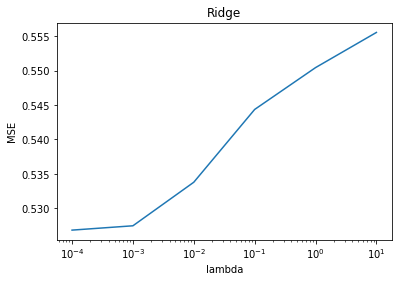

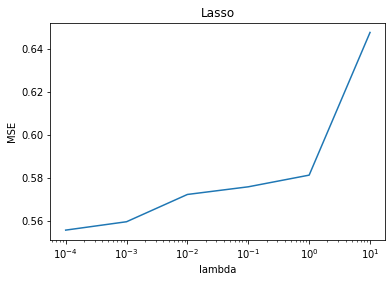

In [19]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that results the minimal mse
# We use is_ridge to indicate which the model is considered.
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
# (against the problem of large variance)
# Lambda = alpha in sklearn
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_arr = []
    lam_arr = []
    classifier = ""

    # Try lambda values from 10^-4 to 10^2. 
    # Record the mse and the lambda values in mse_arr and lam_arr
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    for pow_lam in range(-4, 2):
        lam = float(10 ** pow_lam)
        if is_ridge is True:
          classifier = "Ridge"
          model = Ridge(alpha=lam).fit(X_train_n, y_train_n)
        elif is_ridge is False:
          classifier = "Lasso"
          model = Lasso(alpha=lam).fit(X_train_n, y_train_n)
        mse = mean_squared_error(y_true=y_train_v, y_pred=model.predict(X_train_v))  # compute the mse for this lam
        mse_arr.append(mse) 
        lam_arr.append(lam)
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr))

    # plot of the lambda values and their mse
    plt.figure()
    plt.title(classifier)
    plt.xlabel('lambda')
    plt.ylabel('MSE')
    plt.semilogx(lam_arr, mse_arr)

    # return the optimal lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 12**:
Once you’ve obtained the optimal lambdas for Ridge and Lasso, train these models using these lambdas on the full training data. Then report
the training and test error.

In [20]:
# TODO: train the Ridge and Lasso models using the optimal parameters, and
#       report their MSE
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
# Hints: train these models on the full training data
model_ridge = Ridge(alpha=0.0001)
model_ridge.fit(X_train, y_train)

model_lasso = Lasso(alpha=0.0001)
model_lasso.fit(X_train, y_train)

# Ridge predictions:
mse_ridge_train = mean_squared_error(y_true=y_train, y_pred=model_ridge.predict(X_train))
mse_ridge_test = mean_squared_error(y_true=y_test, y_pred=model_ridge.predict(X_test))
# Lasso predictions:
mse_lasso_train = mean_squared_error(y_true=y_train, y_pred=model_lasso.predict(X_train))
mse_lasso_test = mean_squared_error(y_true=y_test, y_pred=model_lasso.predict(X_test))
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.50332e-17): result may not be accurate.
  overwrite_a=True).T


For Ridge Regression with using degree 2 polynomial expansion and lambda = 0.0001
--------------------------------------------------------------------------------

MSE (Training) = 0.4971
MSE (Testing)  = 0.5094


For Lasso with using degree 2 polynomial expansion and lambda = 0.0001
---------------------------------------------------------------------

MSE (Training) = 0.5139
MSE (Testing)  = 0.5299


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1015.2128776887664, tolerance: 0.3043413221031145
  positive)


## Optional: Try Larger Degrees using K-fold Cross Validation



### **Task 13**
This is an optional task, which worths 5 bonus poitns.

The task is to try basis expansions with higher degrees (up to degree 4) and find the degree that results the best performance. 
Instead of always using the same validation set, you should use k-fold cross validation to find the optimal hyperparameters. 
You should report the optimal hyperparameters (the basis expansion degree and the lambdas) and the MSE of the Ridge and Lasso when you apply the optimal hyperparameters. 

Hints: Use `KFold` to do this automatically. 

In [62]:
# KFold
from sklearn.model_selection import KFold
from collections import defaultdict
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate


In [22]:
# TODO: Try using higher degree basis expansion. Find the degree that gives the minimal mse. 
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################

In [87]:
# 1. The first approach ("step-by-step")
d_range = 5
basis_exp_degree_range=range(2, d_range)
n_splits=5

def mse_withCV(X, y, is_ridge: bool, basis_exp_degree_range):
  MSE_train = defaultdict(list)
  MSE_test = defaultdict(list)

  kf = KFold(n_splits)
  for cv, (train_idx, test_idx) in enumerate(kf.split(X)):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Standardize the training and test data.
    scaler = StandardScaler().fit(X_train)
    scaler.transform(X_train)
    scaler.transform(X_test)

    # Expand the basis of the training and test data.
    for degree in basis_exp_degree_range:
      X_train_exp = expand_basis(X_train, degree)
      X_test_exp = expand_basis(X_test, degree)

      scaler.fit(X_train_exp)
      scaler.transform(X_train_exp)
      scaler.transform(X_test_exp)

      if is_ridge is True:
        # classifier = "Ridge"
        model = Ridge(alpha=0.0001, fit_intercept=True ).fit(X_train_exp, y_train)
      elif is_ridge is False:
        # classifier = "Lasso"
        model = Lasso(alpha=0.0001, fit_intercept=True ).fit(X_train_exp, y_train)
      MSE_train[cv].append(mean_squared_error(y_true=y_train, y_pred=model.predict(X_train_exp)))
      MSE_test[cv].append(mean_squared_error(y_true=y_test, y_pred=model.predict(X_test_exp)))

  return MSE_train, MSE_test

In [ ]:
cv_mse_ridge_train, cv_mse_ridge_test = mse_withCV(X, y, True, basis_exp_degree_range)

In [ ]:
cv_mse_lasso_train, cv_mse_lasso_test = mse_withCV(X, y, False, basis_exp_degree_range)

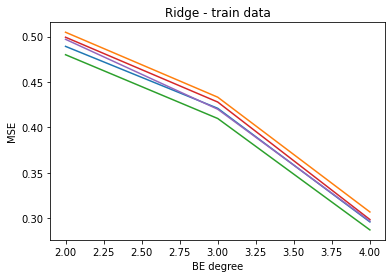

In [79]:
plt.figure()
plt.title("Ridge - train data")
plt.xlabel('BE degree')
plt.ylabel('MSE')
for cv in range(n_splits):
  #print(cv)
  #print(cv_mse_ridge_test[cv])
  plt.plot(basis_exp_degree_range, cv_mse_ridge_train[cv])

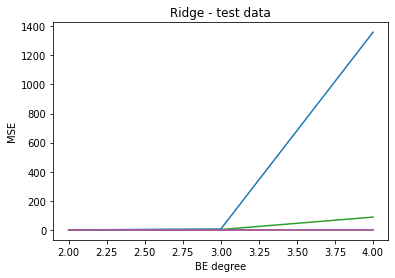

In [80]:
plt.figure()
plt.title("Ridge - test data")
plt.xlabel('BE degree')
plt.ylabel('MSE')
for cv in range(n_splits):
  #print(cv)
  #print(cv_mse_ridge_test[cv])
  plt.plot(basis_exp_degree_range, cv_mse_ridge_test[cv])

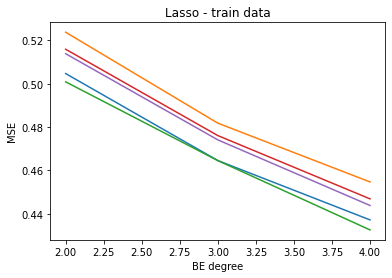

In [84]:
plt.figure()
plt.title("Lasso - train data")
plt.xlabel('BE degree')
plt.ylabel('MSE')
for cv in range(n_splits):
  #print(cv)
  #print(cv_mse_lasso_test[cv])
  plt.plot(basis_exp_degree_range, cv_mse_lasso_train[cv])

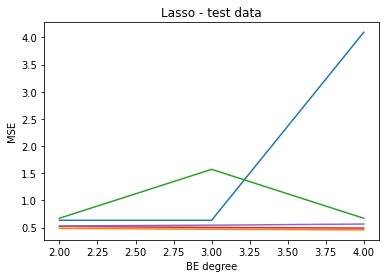

In [85]:
plt.figure()
plt.title("Lasso - test data")
plt.xlabel('BE degree')
plt.ylabel('MSE')
for cv in range(n_splits):
  #print(cv)
  #print(cv_mse_lasso_test[cv])
  plt.plot(basis_exp_degree_range, cv_mse_lasso_test[cv])

In [ ]:
# 2. The second approach (for self-check)

In [74]:
for d in range(2,7):
  
  ridge = make_pipeline(PolynomialFeatures(degree=d), StandardScaler(),
                        Ridge(alpha=0.0001))
  cv_results = cross_validate(ridge, X, y,
                              cv=5, scoring="neg_mean_squared_error",
                              return_estimator=True)
  train_error = -cv_results["train_score"]
  print("Mean squared error of linear regression model with Ridge and degree of {} on the train set:\n{} +/- {}".format(
      d, train_error.mean(), train_error.std()))

Mean squared error of linear regression model with Ridge and degree of 2 on the train set:
0.49283005047220946 +/- 0.008850935997367077
Mean squared error of linear regression model with Ridge and degree of 3 on the train set:
0.4228505657091173 +/- 0.008217227818899072
Mean squared error of linear regression model with Ridge and degree of 4 on the train set:
0.3066086571374406 +/- 0.00691338108079531
Mean squared error of linear regression model with Ridge and degree of 5 on the train set:
0.1855796904076738 +/- 0.006145048145637387
Mean squared error of linear regression model with Ridge and degree of 6 on the train set:
0.11634504979061348 +/- 0.006132716423910848


In [86]:
for d in range(2,7):
  
  ridge = make_pipeline(PolynomialFeatures(degree=d), StandardScaler(),
                        Lasso(alpha=0.0001))
  cv_results = cross_validate(ridge, X, y,
                              cv=5, scoring="neg_mean_squared_error",
                              return_train_score=True,
                              return_estimator=True)
  train_error = -cv_results["train_score"]
  print("Mean squared error of linear regression model with Lasso and degree of {} on the train set:\n{} +/- {}".format(
      d, train_error.mean(), train_error.std()))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 622.8108297814629, tolerance: 0.3082574783052585
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 570.0615790785525, tolerance: 0.3116757784583975
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 618.8400417264783, tolerance: 0.3025208779989794
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 587.86773

Mean squared error of linear regression model with Lasso and degree of 2 on the train set:
0.503947527597833 +/- 0.008765884654206368


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 605.1328868589816, tolerance: 0.3082574783052585
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 652.9458213687826, tolerance: 0.3116757784583975
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 649.7971985238951, tolerance: 0.3025208779989794
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 647.80120

Mean squared error of linear regression model with Lasso and degree of 3 on the train set:
0.46557915428635815 +/- 0.007027902471464176


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 596.0476880297125, tolerance: 0.3082574783052585
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 662.0192937854025, tolerance: 0.3116757784583975
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 617.003883395141, tolerance: 0.3025208779989794
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 712.075532

Mean squared error of linear regression model with Lasso and degree of 4 on the train set:
0.4431765300490461 +/- 0.007777395689626496


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 595.0971429424471, tolerance: 0.3082574783052585
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 519.3900438051853, tolerance: 0.3116757784583975
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 563.1996544798684, tolerance: 0.3025208779989794
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 569.30236

Mean squared error of linear regression model with Lasso and degree of 5 on the train set:
0.42138912100498127 +/- 0.007445384008847052


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 509.86471130964736, tolerance: 0.3082574783052585
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 546.4950870527134, tolerance: 0.3116757784583975
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 501.8399615926476, tolerance: 0.3025208779989794
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 470.4202

Mean squared error of linear regression model with Lasso and degree of 6 on the train set:
0.40252211915499697 +/- 0.007557267900064933


In [ ]:
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################